In [1]:

%load_ext autoreload
%autoreload 2

import os
import sys
import json
import torch

from IPython.display import display, Audio
from tqdm import tqdm
import time
import numpy as np

from after.dataset import SimpleDataset
from after.autoencoder.wrappers import M2LWrapper

2025-08-08 10:11:31.511736: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-08 10:11:31.569482: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-08 10:11:32.727332: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
datapath = "/data/nils/datasets/maestro/processed_m2l_descriptors"

emb_model = M2LWrapper()
dataset = SimpleDataset(path=datapath, keys="all")

retaining  29398  balanced indices from file:  /data/nils/datasets/maestro/processed_m2l_descriptors/balanced_indices.json from original : 29504


In [25]:
data = dataset[3000]

z = data["z"]
# audio = emb_model.decode(z)

# display(Audio(audio.squeeze(), rate=44100))

In [26]:
descr = ["note_density", "average_duration", "pitch_range", "central_pitch"]

midi = data["midi"]
for d in descr:
    descr_signal = data[d]
    print(descr_signal.shape)  # (255,)

(255,)
(255,)
(255,)
(255,)


In [27]:
print(midi.get_end_time())

23.59389030612246


In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pretty_midi
import matplotlib.pyplot as plt
import numpy as np
import pretty_midi

from pretty_midi import PrettyMIDI


def print_notes_sorted_by_start(midi: PrettyMIDI, include_drums=False):
    """
    Print all notes in the MIDI sorted by start time.
    
    Parameters:
    - midi: PrettyMIDI object
    - include_drums: If False, skips percussion instruments
    """
    all_notes = []

    for inst in midi.instruments:
        if not include_drums and inst.is_drum:
            continue
        for note in inst.notes:
            all_notes.append((note.start, inst.name or "Instrument", note))

    # Sort notes by start time
    sorted_notes = sorted(all_notes, key=lambda x: x[0])

    # Print them
    for start, inst_name, note in sorted_notes:
        print(
            f"Start: {note.start:.3f}s | Pitch: {note.pitch} | "
            f"Velocity: {note.velocity} | Duration: {note.end - note.start:.3f}s | "
            f"Instrument: {inst_name}")


import matplotlib.pyplot as plt
import numpy as np
import pretty_midi
import matplotlib.patches as patches

import matplotlib.pyplot as plt
import numpy as np
import pretty_midi
import matplotlib.patches as patches


def plot_midi_with_descriptors(midi: pretty_midi.PrettyMIDI,
                               descriptors: dict,
                               descriptors_resampled: dict = None,
                               tmin: float = None,
                               tmax: float = None,
                               include_drums: bool = False,
                               line_rate: float = None,
                               window: float = 0.1,
                               hop: float = 0.1):
    """
    Plot MIDI note rectangles and aligned descriptors.
    Each descriptor is assumed to span the entire MIDI duration.

    Parameters:
    - midi: pretty_midi.PrettyMIDI object
    - descriptors: dict of descriptor_name -> np.array of shape (N,)
    - tmin, tmax: time limits in seconds
    - include_drums: whether to include drum tracks
    - line_rate: optional sample rate (Hz) at which to draw vertical lines
    """
    num_descr = len(descriptors)
    total_plots = 1 + num_descr
    time_length = midi.get_end_time()

    fig, axes = plt.subplots(total_plots,
                             1,
                             figsize=(12, 2.5 * total_plots),
                             sharex=True)

    # Determine plot range
    if tmin is None:
        tmin = 0
    if tmax is None:
        tmax = time_length

    # --- 1. Accurate Note Plot (Rectangles) ---
    ax0 = axes[0]
    for instrument in midi.instruments:
        if not include_drums and instrument.is_drum:
            continue
        for note in instrument.notes:
            if note.end < tmin or note.start > tmax:
                continue  # Skip notes outside time window
            rect = patches.Rectangle((note.start, note.pitch),
                                     note.end - note.start,
                                     1,
                                     facecolor='blue',
                                     alpha=0.6,
                                     edgecolor='black',
                                     linewidth=0.3)
            ax0.add_patch(rect)

    ax0.set_ylabel("Pitch")
    ax0.set_title("MIDI Notes")
    ax0.set_xlim(tmin, tmax)
    ax0.set_ylim(0, 128)

    # --- 2. Descriptors ---
    for i, (name, signal) in enumerate(descriptors.items()):
        ax = axes[i + 1]
        N = len(
            signal
        )  # time_axis = np.linspace(0 + dt / 2, time_length - dt / 2, N)
        time_axis = np.arange(window / 2, time_length - window / 2 + hop, hop)
        print(time_axis.shape)
        print(time_length)
        ax.plot(time_axis, signal)
        ax.set_ylabel(name)
        ax.grid(True)
        ax.set_xlim(tmin, tmax)

    if descriptors_resampled is not None:
        for i, (name, signal) in enumerate(descriptors_resampled.items()):
            ax = axes[i + 1]
            N = len(signal)
            hop = time_length / N
            time_axis = np.linspace(window / 2, time_length - window / 2, N)
            ax.plot(time_axis, signal, linestyle='--', color='orange')
            ax.set_ylabel(name + " (resampled)")
            ax.grid(True)
            ax.set_xlim(tmin, tmax)

    # --- Vertical Lines at line_rate ---
    if line_rate:
        step = 1.0 / line_rate
        verticals = np.arange(tmin, tmax, step)
        for ax in axes:
            for t in verticals:
                ax.axvline(t,
                           color='gray',
                           linestyle='--',
                           linewidth=0.5,
                           alpha=0.5)

    axes[-1].set_xlabel("Time (s)")
    plt.tight_layout()
    plt.show()


In [6]:
import numpy as np
import pretty_midi

import numpy as np
from scipy.interpolate import interp1d

import numpy as np
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter


def resample_descriptors(descriptors: dict,
                         target_length: int,
                         smoothing_window: int = 17,
                         polyorder: int = 3) -> dict:
    """
    Smooth and resample descriptor curves using Savitzky-Golay filtering and linear interpolation.

    Parameters:
    - descriptors: dict of descriptor_name -> np.ndarray
    - target_length: int, number of desired samples
    - smoothing_window: int, window size for Savitzky-Golay filter (must be odd)
    - polyorder: int, polynomial order for smoothing

    Returns:
    - resampled_descriptors: dict with same keys, resampled and smoothed values
    """
    resampled = {}

    for name, signal in descriptors.items():
        N = len(signal)
        if N == 0 or target_length == 0:
            resampled[name] = np.array([])
            continue
        if np.all(np.isnan(signal)):
            resampled[name] = np.full(target_length, np.nan)
            continue

        # Handle NaNs: simple interpolation before smoothing
        if np.any(np.isnan(signal)):
            valid = ~np.isnan(signal)
            if np.sum(valid) < 2:
                resampled[name] = np.full(target_length, np.nan)
                continue
            interp_func = interp1d(np.flatnonzero(valid),
                                   signal[valid],
                                   kind='linear',
                                   fill_value='extrapolate')
            signal = interp_func(np.arange(N))

        # Ensure smoothing window is valid
        if smoothing_window >= N:
            smoothing_window = N - 1 if N % 2 == 0 else N
        if smoothing_window % 2 == 0:
            smoothing_window -= 1
        if smoothing_window < polyorder + 2:
            smoothing_window = polyorder + 2 | 1  # ensure odd

        # Apply Savitzky–Golay filter
        try:
            smoothed = savgol_filter(signal,
                                     window_length=smoothing_window,
                                     polyorder=polyorder)
        except ValueError:
            smoothed = signal  # fallback if filtering fails

        # Interpolation to target length
        x_old = np.linspace(0, 1, N)
        x_new = np.linspace(0, 1, target_length)
        interp_func = interp1d(x_old, smoothed, kind='linear')
        resampled[name] = interp_func(x_new)

    return resampled


def compute_midi_descriptors(midi: pretty_midi.PrettyMIDI,
                             window_size: float,
                             hop_size: float,
                             playing_notes: bool = False,
                             target_length: int = None) -> dict:
    """
    Compute time-varying MIDI descriptors over a sliding window.

    Returns a dict of:
    - note_density
    - central_pitch
    - average_duration
    - pitch_range_abs
    - pitch_range_var

    Parameters:
    - midi: PrettyMIDI object
    - window_size: window size in seconds
    - hop_size: hop size in seconds
    - playing_notes: if True, considers sounding notes; otherwise, note onsets

    Returns:
    - descriptors: dict of name -> np.ndarray (one value per window)
    """
    # Collect all notes
    all_notes = []
    for instrument in midi.instruments:
        if instrument.is_drum:
            continue
        all_notes.extend(instrument.notes)

    total_time = midi.get_end_time()
    times = np.arange(0, total_time - window_size + hop_size,
                      hop_size) + window_size / 2
    num_frames = len(times)

    # Initialize outputs
    note_density = np.zeros(num_frames)
    central_pitch = np.full(num_frames, np.nan)
    average_duration = np.full(num_frames, np.nan)
    pitch_range_abs = np.full(num_frames, np.nan)
    pitch_range_var = np.full(num_frames, np.nan)

    for i, center in enumerate(times):
        t_start = center - window_size / 2
        t_end = center + window_size / 2

        if playing_notes:
            notes = [
                n for n in all_notes if n.start <= t_end and n.end >= t_start
            ]
        else:
            notes = [n for n in all_notes if t_start <= n.start < t_end]

        if notes:
            pitches = np.array([n.pitch for n in notes])
            durations = np.array([n.end - n.start for n in notes])

            note_density[i] = len(notes)
            central_pitch[i] = np.mean(pitches)
            average_duration[i] = np.mean(durations)
            pitch_range_abs[i] = np.max(pitches) - np.min(pitches)
            pitch_range_var[i] = np.var(pitches) / (
                12.0**2)  # normalized to 1 octave variance

    out = {
        "note_density": note_density,
        "central_pitch": central_pitch,
        "average_duration": average_duration,
        "pitch_range_abs": pitch_range_abs,
        "pitch_range_var": pitch_range_var,
    }

    if target_length is not None:
        out = resample_descriptors(out, target_length)

    return out

In [7]:
# display(Audio(audio.squeeze(), rate=44100))

In [8]:
z.shape

(64, 255)

Computed descriptors in 0.03 seconds
Computed descriptors in 0.03 seconds
(449,)
23.364583333333332
(449,)
23.364583333333332
(449,)
23.364583333333332
(449,)
23.364583333333332
(449,)
23.364583333333332


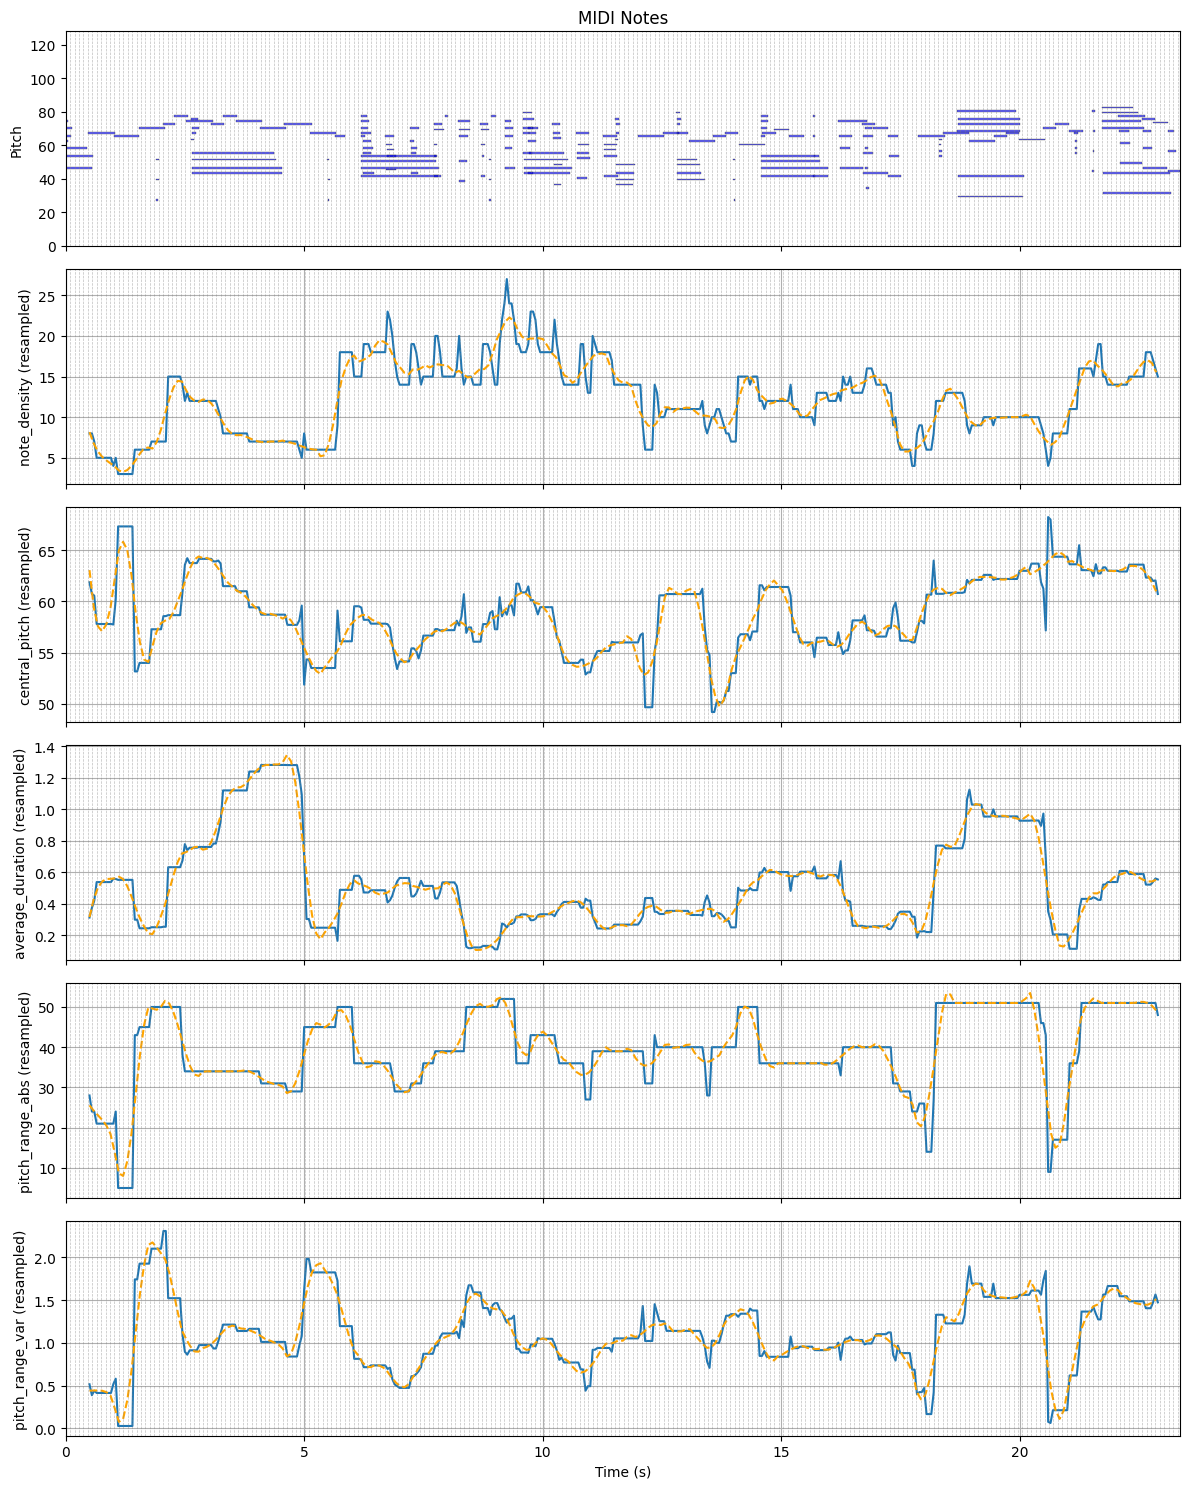

In [191]:
from pretty_midi import PrettyMIDI

window_size = 1.
hop_size = 0.05

descr = ["note_density", "average_duration", "pitch_range", "central_pitch"]
descriptor_signals = {}

# descriptor_signals["note_density_computed"] = compute_note_density(
#     data["midi"], window_size=window_size, hop_size=hop_size)

# descriptor_signals[
#     "note_density_computed_playingnotes"] = compute_note_density(
#         data["midi"],
#         window_size=window_size,
#         hop_size=hop_size,
#         playing_notes=True)

# descriptor_signals["central_pitch_computed"] = compute_central_pitch(
#     data["midi"],
#     window_size=window_size,
#     hop_size=hop_size,
#     playing_notes=True)
import time

st = time.time()
descriptors = compute_midi_descriptors(data["midi"],
                                       window_size=window_size,
                                       hop_size=hop_size,
                                       playing_notes=True)

end = time.time()
print(f"Computed descriptors in {end - st:.2f} seconds")

sr = time.time()
descriptors_resampled = compute_midi_descriptors(data["midi"],
                                                 window_size=window_size,
                                                 hop_size=hop_size,
                                                 playing_notes=True,
                                                 target_length=255)
print(f"Computed descriptors in {end - st:.2f} seconds")

# descriptors_resampled = resample_descriptors(descriptors, target_length=255)

# descriptor_signals.update({d: data[d] for d in descr})
# print_notes_sorted_by_start(midi=data["midi"], include_drums=False)
plot_midi_with_descriptors(data["midi"],
                           descriptors,
                           descriptors_resampled,
                           tmin=None,
                           tmax=None,
                           line_rate=44100 / 4096,
                           window=window_size,
                           hop=hop_size)  #, tmin=1., tmax=1.7)


In [194]:
import numpy as np
import matplotlib.pyplot as plt

# Initialize empty lists to collect values
all_descriptor_values = {
    "note_density": [],
    "central_pitch": [],
    "average_duration": [],
    "pitch_range_abs": [],
    "pitch_range_var": []
}

# Loop through dataset
indices = np.random.choice(range(len(dataset)), size=1000,
                           replace=False)  # Sample 1000 random indices
for i in tqdm(indices):
    data = dataset[i]
    midi = data["midi"]

    descriptors = compute_midi_descriptors(midi,
                                           window_size=window_size,
                                           hop_size=hop_size,
                                           playing_notes=True)

    # Append descriptor values (flatten across all files)
    for name, values in descriptors.items():
        # Filter out NaNs
        all_descriptor_values[name].extend(values[~np.isnan(values)])

# Convert lists to arrays
for name in all_descriptor_values:
    all_descriptor_values[name] = np.array(all_descriptor_values[name])


100%|██████████| 1000/1000 [00:45<00:00, 21.84it/s]


In [ ]:
all_descriptor_values

In [201]:
all_descriptor_values2 = {
    k: v
    for k, v in all_descriptor_values.items() if len(v) > 0
}

In [202]:
all_descriptor_values2["average_duration"] = [
    f for f in all_descriptor_values2["average_duration"] if f < 3
]

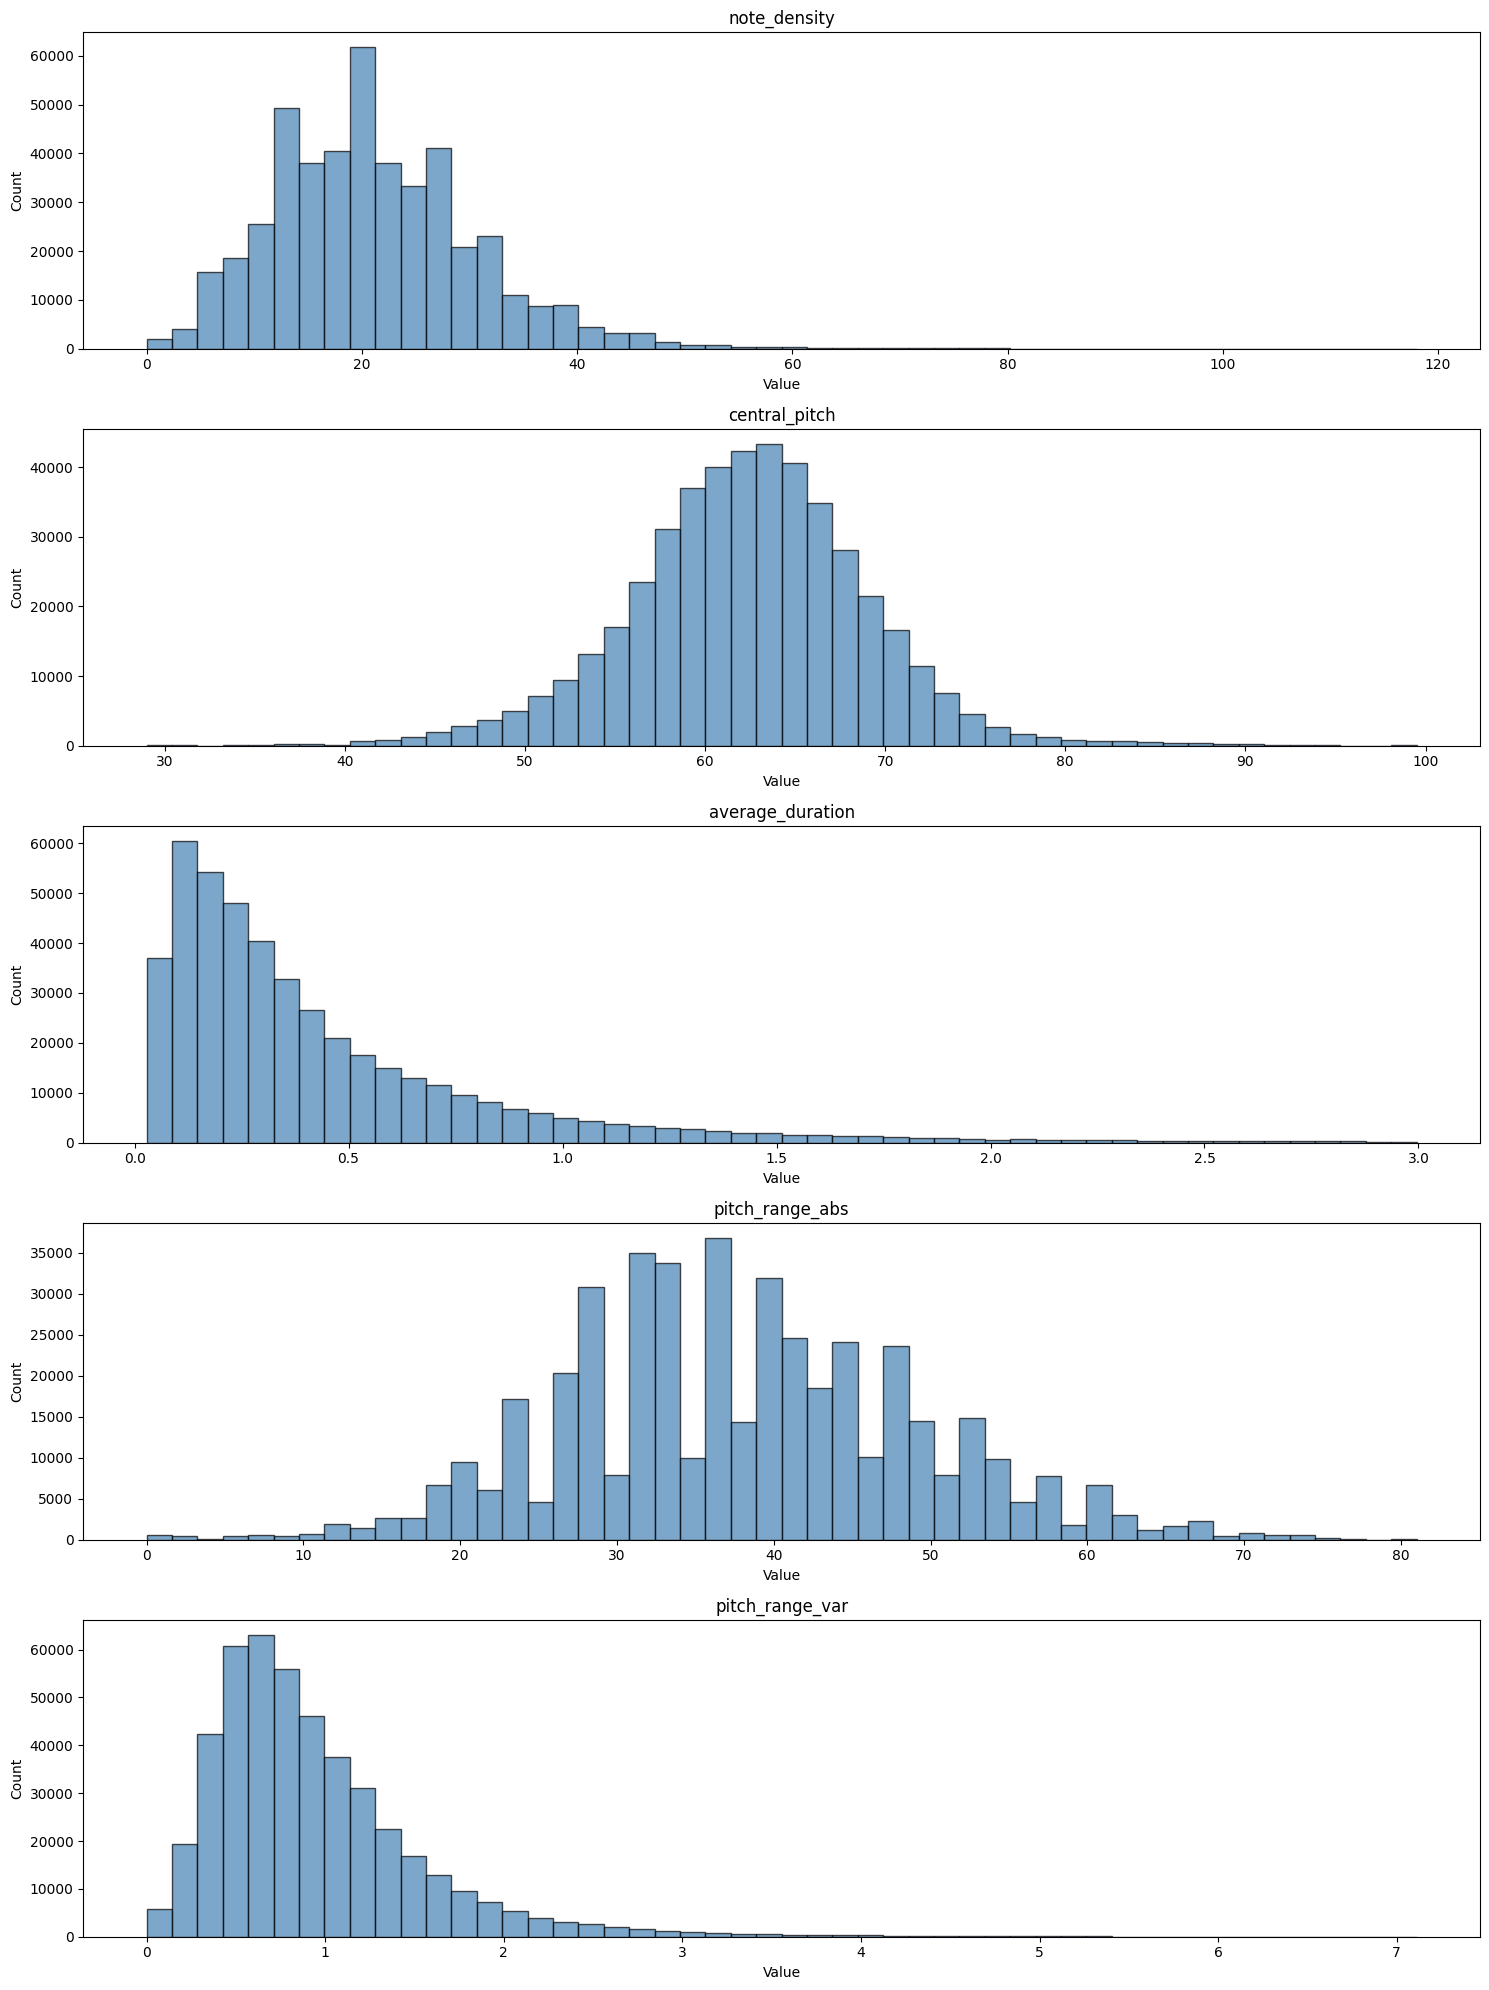

In [203]:
n_cols = 1
n_rows = int(np.ceil(len(all_descriptor_values2) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
axes = axes.flatten()

for i, (name, values) in enumerate(all_descriptor_values2.items()):
    ax = axes[i]
    ax.hist(values, bins=50, alpha=0.7, color='steelblue', edgecolor='black')
    ax.set_title(name)
    ax.set_xlabel("Value")
    ax.set_ylabel("Count")

# Remove empty subplots if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()
